# Using Epidemic Size

In [16]:
### import modules
import numpy as np
from utils import seir_ivp, run_modified_seir_ivp

In [8]:
from scipy.integrate import solve_ivp, odeint
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
def run_scenarios_size(y0: list, t: int, size: float, R0s: np.ndarray, sigma: float, gamma: float, \
    epss: np.ndarray, measured: int):  
    s0, e0, i0, r0 = y0
    df_R0s = []; df_epss = []; df_fvs = []
    covs = ['Below fc', 'Slightly Above fc', 'Above fc']; df_covs = []
    df_r_perc_leakys = []; df_r_perc_aons = []; df_r_perc_diffs = []
    df_rs = []; df_rleakys = []; df_raons = []

    for R0 in R0s:
        beta = R0 * gamma
        sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), dense_output=True)
        #r = sol.y[3]; r10 = r[-1]*0.1; r25 = r[-1]*0.25

        def _reach_size10(t, y, beta, sigma, gamma): return y[3] - 0.1
        def _reach_size25(t, y, beta, sigma, gamma): return y[3] - 0.25

        _reach_size10.terminate=True
        _reach_size25.terminate=True
                
        for eps in epss:
            if size == 0:
                fc = 1/eps * (1 - 1/R0)
                tv = -1
                t_new = measured
            else:
                if size == 0.1:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size10, dense_output=True)
                elif size == 0.25:
                    sol = solve_ivp(seir_ivp, [0, t], y0, args=(beta, sigma, gamma), \
                        events=_reach_size25, dense_output=True)

                if np.array(sol.t_events).size == 0:
                    fc = 99999; fv = 99999; r_perc_leaky = 99999; r_perc_aon = 99999; r_perc_diff = 99999
                else:
                    s_temp = np.ravel(np.array(sol.y_events[0]))[0]
                    tv = np.ravel(np.array(sol.t_events))[0]
                    fc = 1/eps * (1 - 1/(R0*s_temp))
                    t_new = tv + measured
                        
            for cov in covs:
                if fc != 99999:
                    if cov == 'Below fc':
                        fv = fc * 0.8
                    elif cov == 'Slightly Above fc':
                        fv = 1 - ((1 - fc) * 0.8)
                    else:
                        fv = 1 - ((1 - fc) * 0.5)

                    if fv < 0:
                        fv = 0
                    elif fv > 0.98:
                        fv = 0.98
                    else:
                        fv = fv
                        
                    sol_vax = solve_ivp(seir_ivp, [0, t_new], y0, args=(beta, sigma, gamma), dense_output=True)
                    r_vax = sol_vax.y[3]
                        
                    _, _, _, _, _, _, r_leaky = run_modified_seir_ivp(y0, t_new, tv, beta, sigma, gamma, fv, eps, mode='leaky')
                    _, _, _, _, _, _, r_aon = run_modified_seir_ivp(y0, t_new, tv, beta, sigma, gamma, fv, eps, mode='aon')

                    r_perc_leaky = (r_vax[-1] - r_leaky[-1]) / r_vax[-1] * 100
                    r_perc_aon = (r_vax[-1] - r_aon[-1]) / r_vax[-1] * 100
                    r_perc_diff = r_perc_aon - r_perc_leaky

                df_R0s.append(R0)
                df_epss.append(eps)
                df_fvs.append(fv)
                df_covs.append(cov)
                df_r_perc_leakys.append(r_perc_leaky)
                df_r_perc_aons.append(r_perc_aon)
                df_r_perc_diffs.append(r_perc_diff)
                #df_rs.append(r_vax[-1])
                #df_rleakys.append(r_leaky[-1])
                #df_raons.append(r_aon[-1])

    # build dataframe                        
    data = {'R0': df_R0s, 'VE': df_epss, 'Vax Coverage': df_covs, 'fv': df_fvs, \
        'Leaky': df_r_perc_leakys, 'AON': df_r_perc_aons, 'Diff': df_r_perc_diffs}
        #'r': df_rs, 'r_leaky': df_rleakys, 'r_aon': df_raons}
    vax_df = pd.DataFrame(data=data)

    return vax_df
    

In [29]:
def plot_scenarios_size(df1: pd.DataFrame, df2: pd.DataFrame, df3: pd.DataFrame, dim: int = 2):
    r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)
    plot_r0, plot_eps = np.nan_to_num(np.meshgrid(r0s, epss, indexing='ij'))

    # pre
    below_df1 = df1[df1['Vax Coverage'] == 'Below fc']
    slabove_df1 = df1[df1['Vax Coverage'] == 'Slightly Above fc']
    above_df1 = df1[df1['Vax Coverage'] == 'Above fc']

    #pre_below = np.nan_to_num(np.reshape(below_df1['Diff'].to_numpy(), np.shape(plot_r0)))  
    pre_below = np.nan_to_num(np.reshape(below_df1['Diff'].to_numpy(), np.shape(plot_r0))) 
    pre_slabove = np.nan_to_num(np.reshape(slabove_df1['Diff'].to_numpy(), np.shape(plot_r0)))
    pre_above = np.nan_to_num(np.reshape(above_df1['Diff'].to_numpy(), np.shape(plot_r0)))

    pre_below = np.ma.masked_where(pre_below == 99999, pre_below)
    pre_slabove = np.ma.masked_where(pre_slabove == 99999, pre_slabove)
    pre_above = np.ma.masked_where(pre_above == 99999, pre_above)

    # post10
    below_df2 = df2[df2['Vax Coverage'] == 'Below fc']
    slabove_df2 = df2[df2['Vax Coverage'] == 'Slightly Above fc']
    above_df2 = df2[df2['Vax Coverage'] == 'Above fc']

    post10_below = np.nan_to_num(np.reshape(below_df2['Diff'].to_numpy(), np.shape(plot_r0)))    
    post10_slabove = np.nan_to_num(np.reshape(slabove_df2['Diff'].to_numpy(), np.shape(plot_r0)))
    post10_above = np.nan_to_num(np.reshape(above_df2['Diff'].to_numpy(), np.shape(plot_r0)))

    post10_below = np.ma.masked_where(post10_below == 99999, post10_below)
    post10_slabove = np.ma.masked_where(post10_slabove == 99999, post10_slabove)
    post10_above = np.ma.masked_where(post10_above == 99999, post10_above)

    # post30
    below_df3 = df3[df3['Vax Coverage'] == 'Below fc']
    slabove_df3 = df3[df3['Vax Coverage'] == 'Slightly Above fc']
    above_df3 = df3[df3['Vax Coverage'] == 'Above fc']

    post30_below = np.nan_to_num(np.reshape(below_df3['Diff'].to_numpy(), np.shape(plot_r0)))    
    post30_slabove = np.nan_to_num(np.reshape(slabove_df3['Diff'].to_numpy(), np.shape(plot_r0)))
    post30_above = np.nan_to_num(np.reshape(above_df3['Diff'].to_numpy(), np.shape(plot_r0)))

    post30_below = np.ma.masked_where(post30_below == 99999, post30_below)
    post30_slabove = np.ma.masked_where(post30_slabove == 99999, post30_slabove)
    post30_above = np.ma.masked_where(post30_above == 99999, post30_above)

    if dim == 3:
        fig, axes = plt.subplots(3,3, facecolor='w', figsize=(20,20), gridspec_kw=dict(width_ratios=[1,1,1]), \
            subplot_kw={'projection': '3d'})
        norm = plt.Normalize(np.min(np.log(pre_below+1)), np.max(np.log(pre_below+1)))

        # Pre-transmission
        surf1 = axes[0,0].plot_surface(plot_r0, plot_eps, np.log(pre_below+1), rstride=1, norm=norm, cstride=1, cmap='viridis')
        axes[0,0].set_title('0% | Below $f^*_V$')

        axes[0,1].plot_surface(plot_r0, plot_eps, np.log(pre_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[0,1].set_title('0% | Slightly Above $f^*_V$')

        axes[0,2].plot_surface(plot_r0, plot_eps, np.log(pre_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[0,2].set_title('0% | Above $f^*_V$')
        axes[0,2].set_zlabel('$log(P_A - P_L + 1)$')


        # 10 days post-tranmission
        axes[1,0].plot_surface(plot_r0, plot_eps, np.log(post10_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[1,0].set_title('10% | Below $f^*_V$')

        axes[1,1].plot_surface(plot_r0, plot_eps, np.log(post10_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[1,1].set_title('10% | Slightly Above $f^*_V$')

        axes[1,2].plot_surface(plot_r0, plot_eps, np.log(post10_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[1,2].set_title('10% | Above $f^*_V$')
        axes[1,2].set_zlabel('$log(P_A - P_L + 1)$')

        # 30 days post-transmission
        axes[2,0].plot_surface(plot_r0, plot_eps, np.log(post30_below+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[2,0].set_title('25% | Below $f^*_V$')

        axes[2,1].plot_surface(plot_r0, plot_eps, np.log(post30_slabove+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[2,1].set_title('25% | Slightly Above $f^*_V$')

        axes[2,2].plot_surface(plot_r0, plot_eps, np.log(post30_above+1), norm=norm, rstride=1, cstride=1, cmap='viridis')
        axes[2,2].set_title('25% | Above $f^*_V$')
        axes[2,2].set_zlabel('$log(P_A - P_L + 1)$')

        axs = np.array(axes)
        for ax in axs.reshape(-1):
            ax.set_xlabel('$R_{0,V}$')
            ax.set_ylabel('Vaccine Efficacy')
            ax.view_init(elev=30, azim=120)

        cb = fig.colorbar(mappable=surf1, ax=axes, fraction=0.02, shrink=0.5)
        cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), surf1.get_clim())
        cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
    
        return fig
    
    elif dim == 2:
        # set color-scale
        fig, axes = plt.subplots(3,3, facecolor='w', figsize=(15,15), sharex=True, sharey=True, \
            gridspec_kw=dict(width_ratios=[1,1,1]))
        norm = plt.Normalize(np.min(np.log(pre_below+1)), np.max(np.log(pre_below+1)))

        # Pre-transmission 
        proj = axes[0,0].contourf(plot_r0, plot_eps, np.log(pre_below+1), norm=norm, cmap='viridis')
        axes[0,0].set_title('0% | Below $f^*_V$')
        axes[0,0].set_ylabel('Vaccine Efficacy')

        axes[0,1].contourf(plot_r0, plot_eps, np.log(pre_slabove+1), norm=norm, cmap='viridis')
        axes[0,1].set_title('0% | Slightly Above $f^*_V$')

        #ax3 = fig.add_subplot(133)
        axes[0,2].contourf(plot_r0, plot_eps, np.log(pre_above+1), norm=norm, cmap='viridis')
        axes[0,2].set_title('0% | Above $f^*_V$')

        # 10 days post-transmission
        axes[1,0].contourf(plot_r0, plot_eps, np.log(post10_below+1), norm=norm, cmap='viridis')
        axes[1,0].set_title('10% | Below $f^*_V$')
        axes[1,0].set_ylabel('Vaccine Efficacy')

        axes[1,1].contourf(plot_r0, plot_eps, np.log(post10_slabove+1), norm=norm, cmap='viridis')
        axes[1,1].set_title('10%| Slightly Above $f^*_V$')

        axes[1,2].contourf(plot_r0, plot_eps, np.log(post10_above+1), norm=norm, cmap='viridis')
        axes[1,2].set_title('10% | Above $f^*_V$')

        # 30 days post-transmission
        axes[2,0].contourf(plot_r0, plot_eps, np.log(post30_below+1), norm=norm, cmap='viridis')
        axes[2,0].set_title('30%  | Below $f^*_V$')
        axes[2,0].set_ylabel('Vaccine Efficacy')
        axes[2,0].set_xlabel('$R_{0,V}$')

        axes[2,1].contourf(plot_r0, plot_eps, np.log(post30_slabove+1), norm=norm, cmap='viridis')
        axes[2,1].set_title('30% | Slightly Above $f^*_V$')
        axes[2,1].set_xlabel('$R_{0,V}$')

        axes[2,2].contourf(plot_r0, plot_eps, np.log(post30_above+1), norm=norm, cmap='viridis')
        axes[2,2].set_title('30% | Above $f^*_V$')
        axes[2,2].set_xlabel('$R_{0,V}$')

        fig.tight_layout(pad=0.1)
        cb = fig.colorbar(mappable=proj, ax=axes, fraction=0.02, shrink=0.5)
        cblabels = np.interp(cb.ax.get_yticks(), cb.ax.get_ylim(), proj.get_clim())
        cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))
        
        return fig

## Measured 30 Days After Vaccination

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_9899/720072492.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


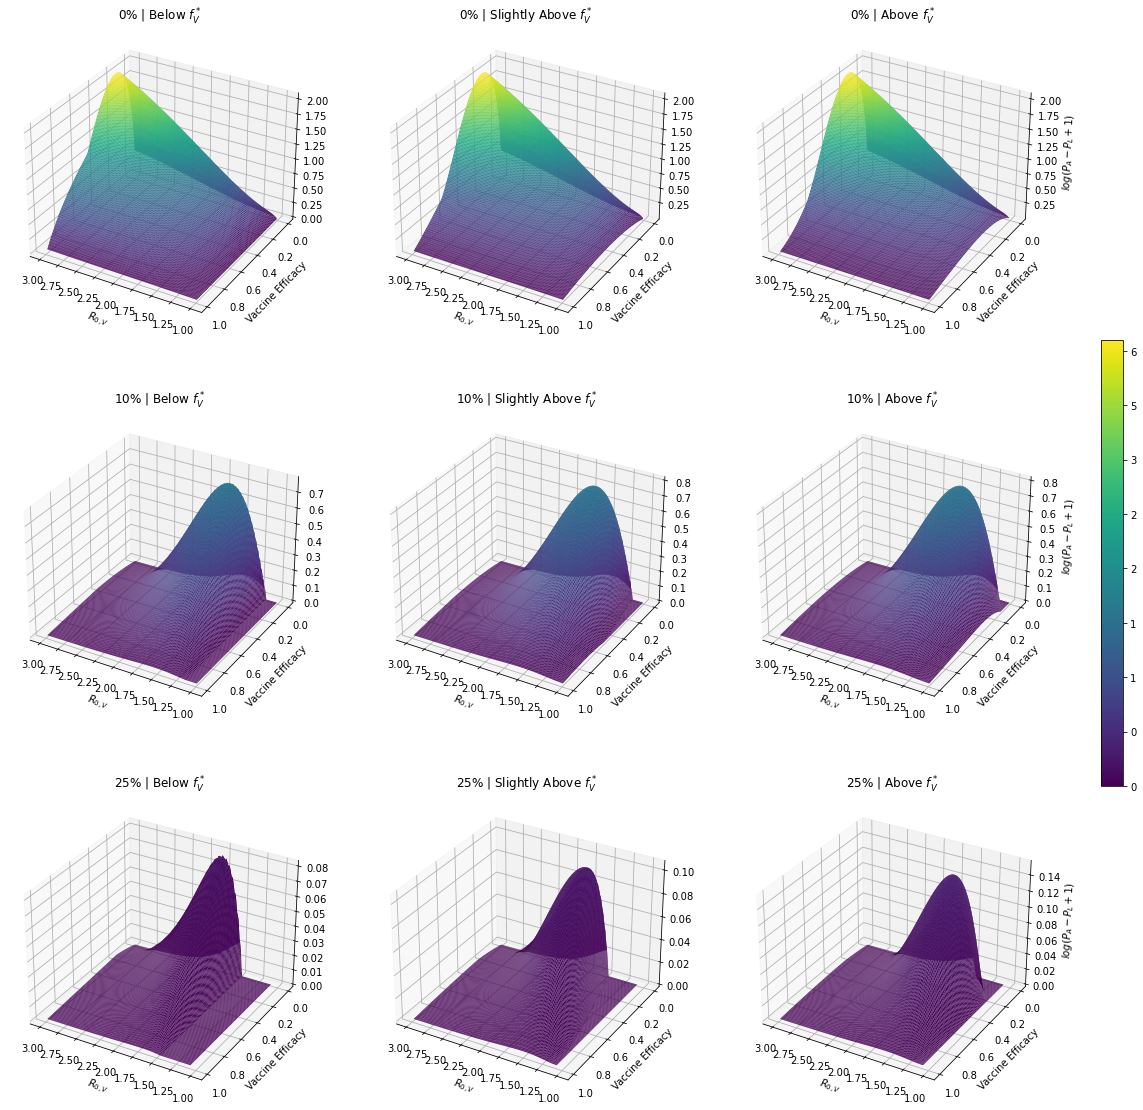

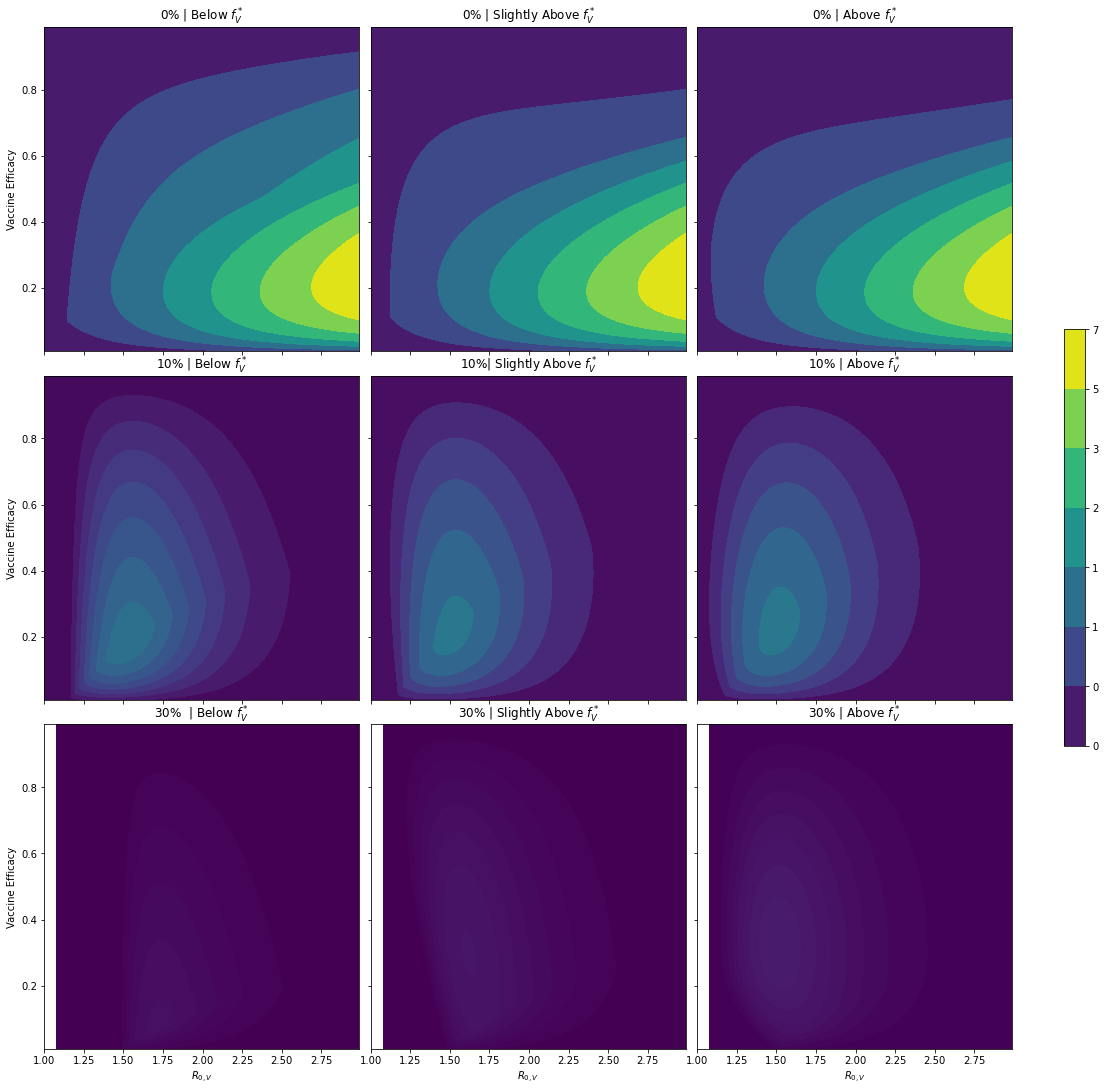

In [30]:
sigma = 1/4; gamma = 1/4; t = 300
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_30 = run_scenarios_size(y0, t, 0, r0s, sigma, gamma, epss, measured=30)
epi10_df_30 = run_scenarios_size(y0, t, 0.1, r0s, sigma, gamma, epss, measured=30)
epi25_df_30 = run_scenarios_size(y0, t, 0.25, r0s, sigma, gamma, epss, measured=30)

fig_3d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_30, epi10_df_30, epi25_df_30, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 60 Days After Vaccination

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_9899/720072492.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


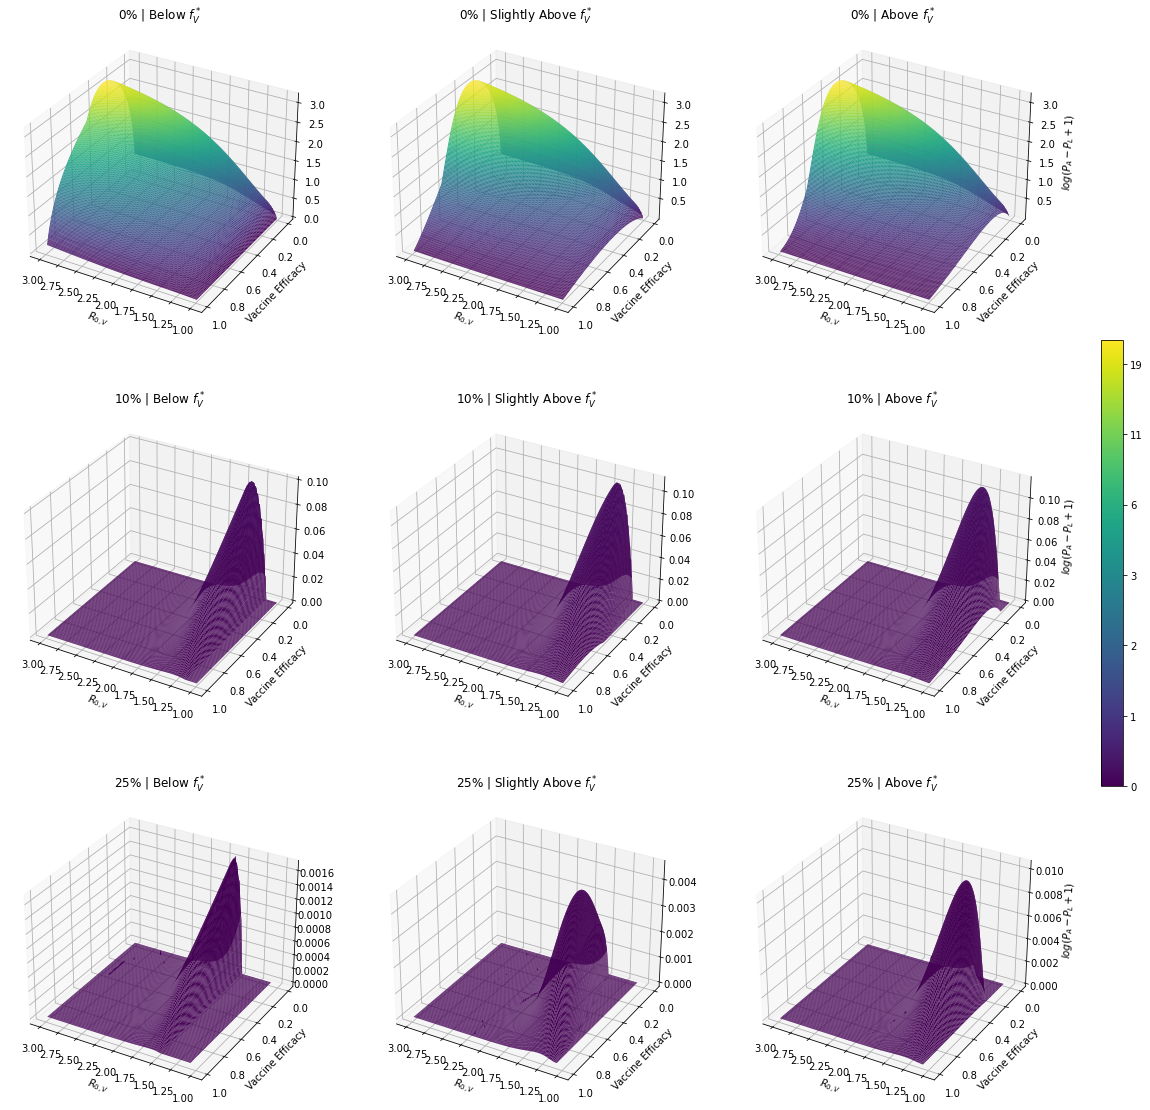

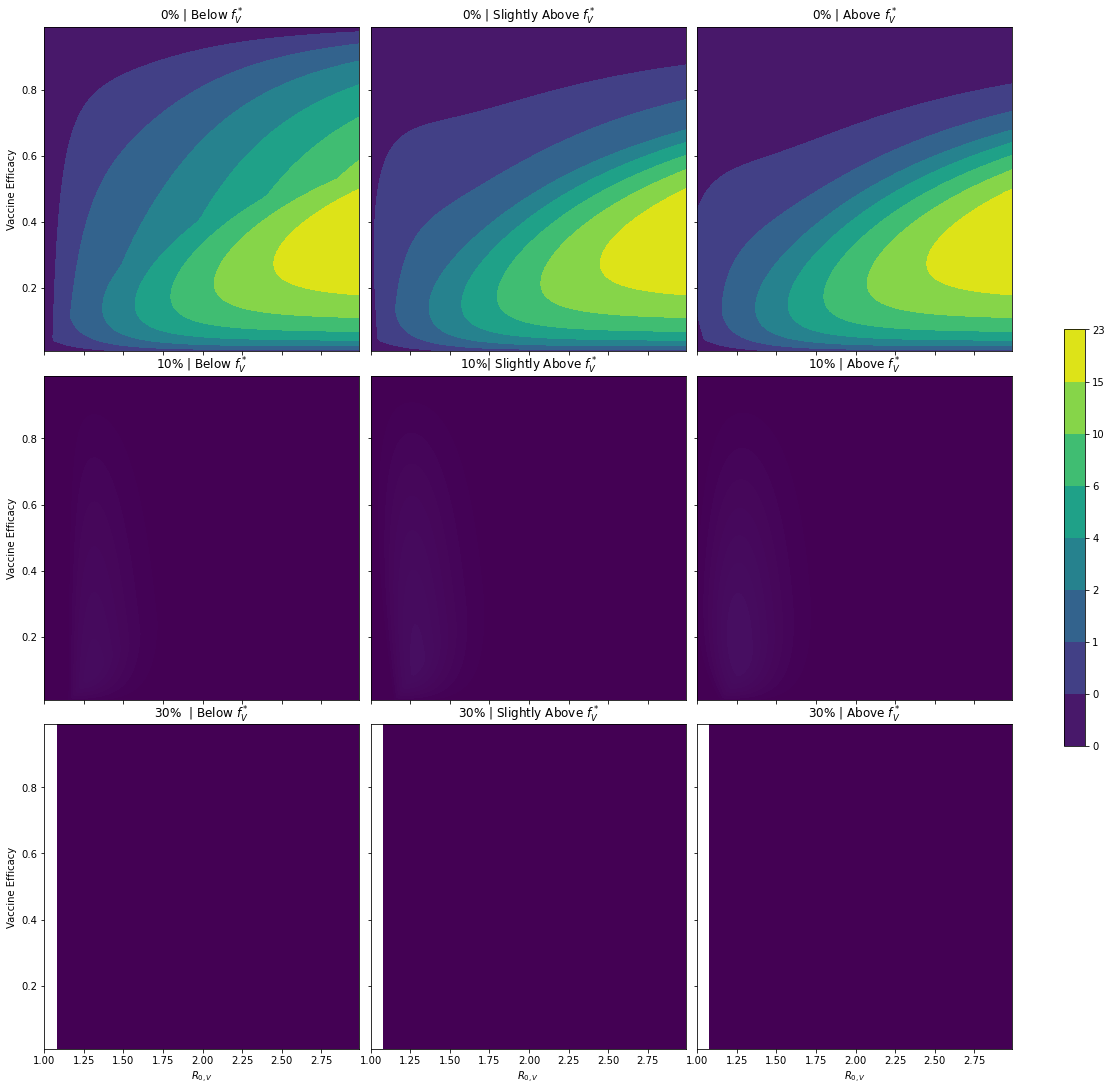

In [31]:
sigma = 1/4; gamma = 1/4; t = 300
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_60 = run_scenarios_size(y0, t, 0, r0s, sigma, gamma, epss, measured=60)
epi10_df_60 = run_scenarios_size(y0, t, 0.1, r0s, sigma, gamma, epss, measured=60)
epi25_df_60 = run_scenarios_size(y0, t, 0.25, r0s, sigma, gamma, epss, measured=60)

fig_3d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_60, epi10_df_60, epi25_df_60, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 100 Days After Vaccination

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_9899/720072492.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


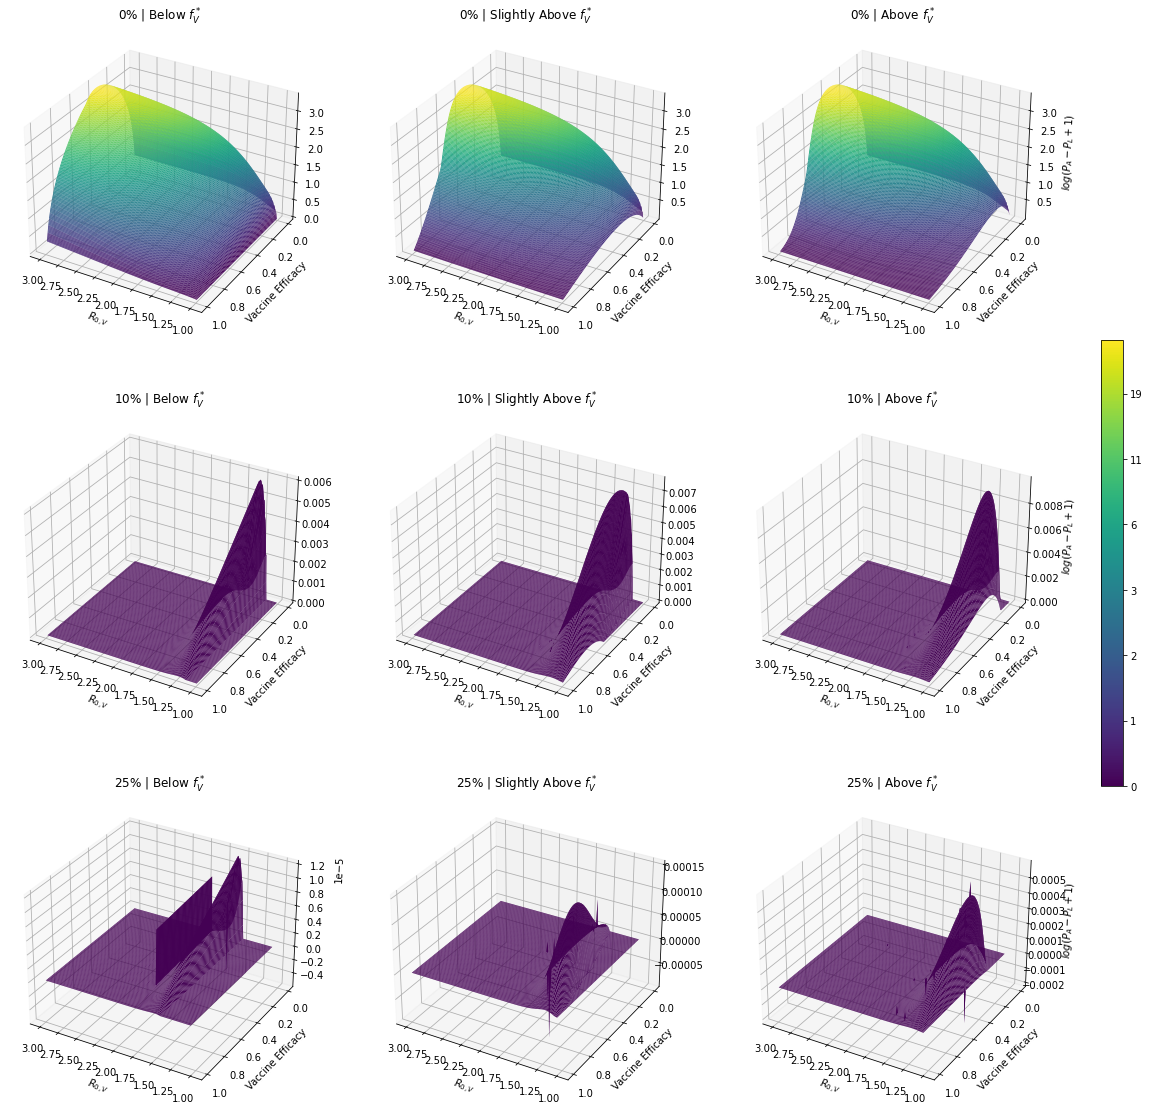

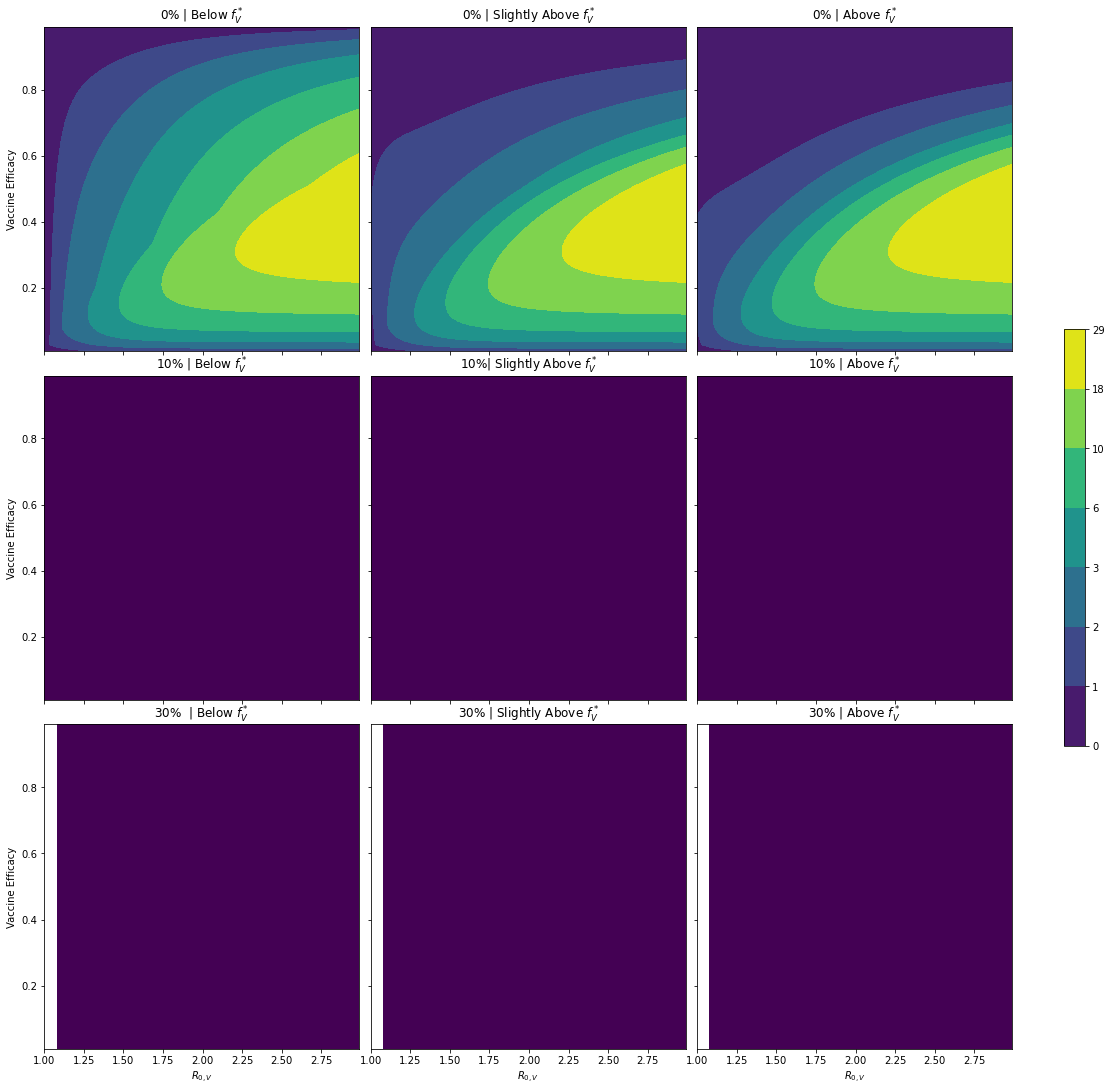

In [32]:
sigma = 1/4; gamma = 1/4; t = 300
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_100 = run_scenarios_size(y0, t, 0, r0s, sigma, gamma, epss, measured=100)
epi10_df_100 = run_scenarios_size(y0, t, 0.1, r0s, sigma, gamma, epss, measured=100)
epi25_df_100 = run_scenarios_size(y0, t, 0.25, r0s, sigma, gamma, epss, measured=100)

fig_3d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_100, epi10_df_100, epi25_df_100, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')

## Measured 300 Days After Vaccination (End of Pandemic)

/var/folders/l5/z1zgtcc52355lzh_8yrfzxnw0000gn/T/ipykernel_9899/720072492.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(np.round(np.exp(cblabels)-1).astype(int))


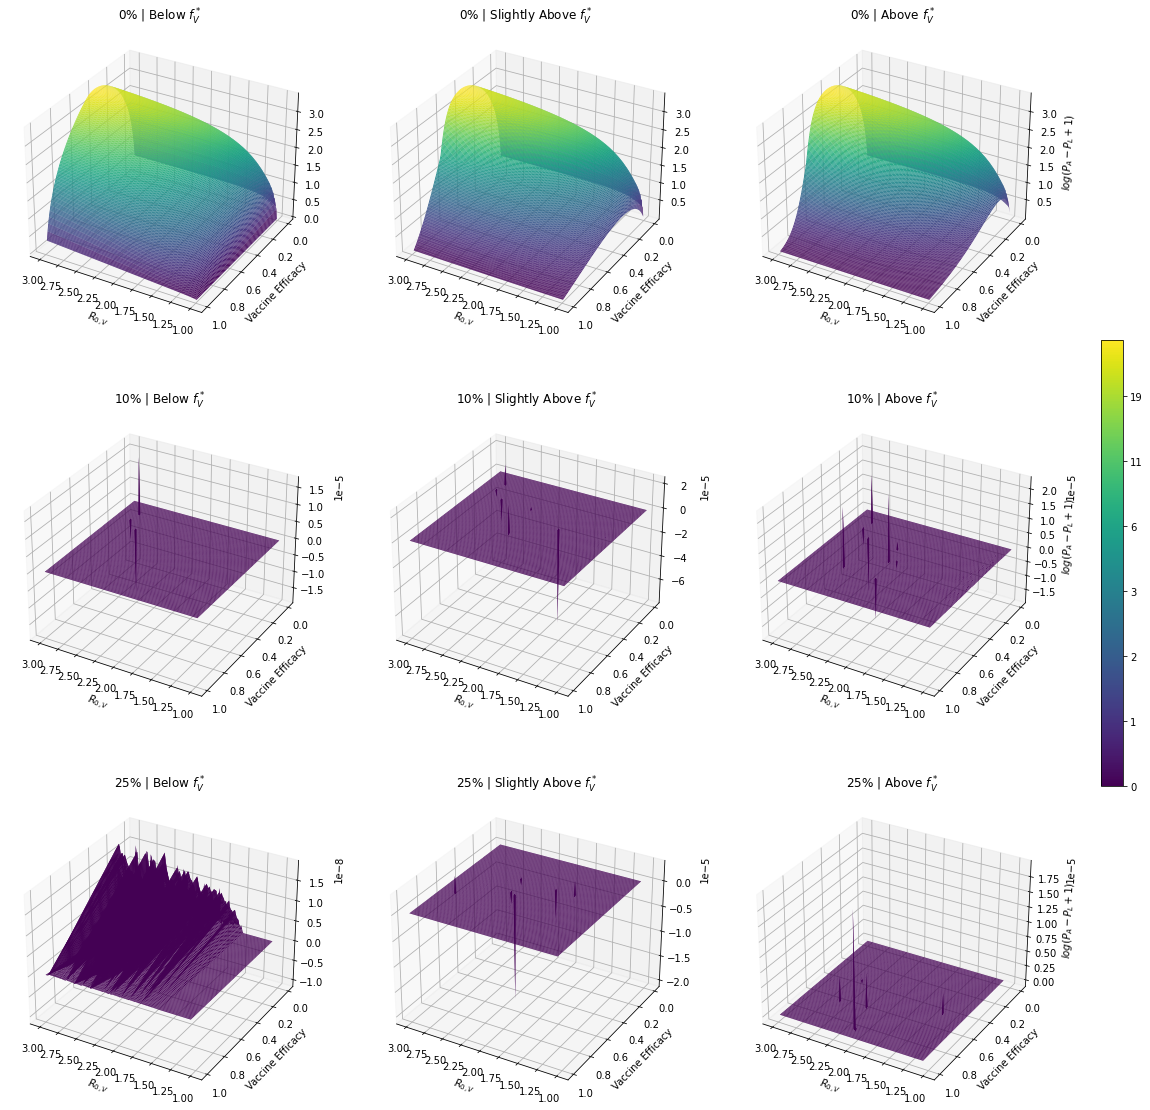

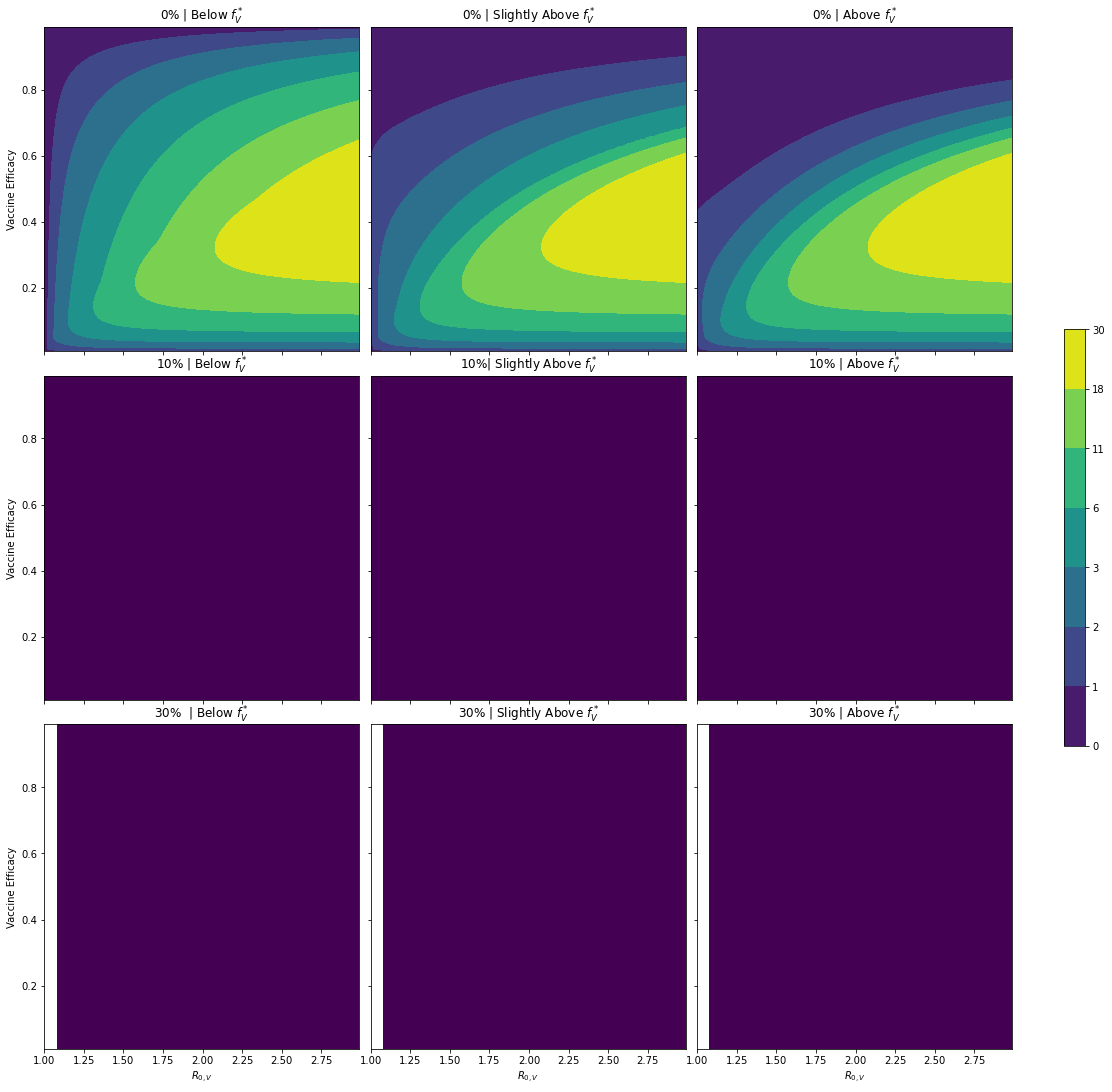

In [33]:
sigma = 1/4; gamma = 1/4; t = 300
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = [s0, e0, i0, r0]
r0s = np.arange(1.0, 3.0, 0.01); epss = np.arange(0.01, 1.0, 0.01)

epi0_df_300 = run_scenarios_size(y0, t, 0, r0s, sigma, gamma, epss, measured=300)
epi10_df_300 = run_scenarios_size(y0, t, 0.1, r0s, sigma, gamma, epss, measured=300)
epi25_df_300 = run_scenarios_size(y0, t, 0.25, r0s, sigma, gamma, epss, measured=300)

fig_3d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=3)
#plt.savefig('epidemicsize_3d.jpg', bbox_inches='tight')
fig_2d = plot_scenarios_size(epi0_df_300, epi10_df_300, epi25_df_300, dim=2)
#plt.savefig('epidemicsize_2d.jpg', bbox_inches='tight')